In [9]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [10]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [11]:
from PortfolioConstruction.factor import construct_factor
from PortfolioConstruction.performance import calc_performance, calc_cum_returns, plot_corr, plot_perf

In [12]:
country_data_path = '../Data/country_data'
macro_data_path = '../Data/macro_factors'
style_data_path = '../Data/style_factors'
cluster_path = '../Outputs/country_clusters'
output_path = '../Outputs/bond'

In [13]:
start_date = '2003-10-01'

## Read data

In [14]:
bnd_idx_price = pd.read_csv(os.path.join(country_data_path, 'EMBIG_index.csv'))
bnd_idx_price.Date = pd.to_datetime(bnd_idx_price.Date, format='%YM%m')
bnd_idx_price.set_index('Date', inplace=True)

In [15]:
bnd_idx_price_bofa = pd.read_excel(os.path.join(country_data_path, 'ice_bofa_sovereign_indices_data.xlsx'), 
                            sheet_name='px_last data',
                            skiprows=3,
                            header=0)

bnd_idx_price_bofa.drop(index=[0, 1], inplace=True)
bnd_idx_price_bofa.rename(columns={"Unnamed: 0":"Date"}, inplace=True)
bnd_idx_price_bofa.set_index('Date', inplace=True)
bnd_idx_price_bofa = bnd_idx_price_bofa.astype('float')
bnd_idx_price_bofa_monthly = bnd_idx_price_bofa.resample('M').last()
bnd_idx_price_bofa_monthly.replace(0, np.nan, inplace=True)

In [16]:
ticker_all = pd.read_csv(os.path.join(country_data_path, 'ice_bofa_sovereign_indices_summary.csv'), skipinitialspace=True)

# optional: can apply filter to exclude some countries; this dictionary will be used to loop for regression
# ticker = ticker_all.loc[(ticker_all['Number of Issues'] > 5) & (ticker_all['Sum of Market Value (mm, USD)'] > 10000), :].copy()
ticker = ticker_all.copy()

ticker['Country'] = ticker['Full Index Name'].apply(lambda x:' '.join(x.split()[4:-2]))
ticker['Index Full Name'] = ticker['Index BBG Ticker'] + ' Index'
ticker_dict = pd.Series(data=ticker['Country'].values, index=ticker['Index Full Name']).to_dict()

In [17]:
bnd_idx_price_bofa_monthly.columns = bnd_idx_price_bofa_monthly.columns.map(ticker_dict)

In [18]:
set(bnd_idx_price_bofa_monthly.columns) - set(bnd_idx_price.columns)

{'Algeria',
 'Armenia',
 'Aruba',
 'Bahamas',
 'Bahrain',
 'Barbados',
 'Bolivia',
 'Egypt',
 'Fiji',
 'Greece',
 'Honduras',
 'Iceland',
 'Israel',
 'Ivory Coast',
 'Kenya',
 'Latvia',
 'Mozambique',
 'Paraguay',
 'Qatar',
 'Romania',
 'Russia',
 'Rwanda',
 'Slovakia',
 'Slovenia',
 'South Korea',
 'Spain',
 'Thailand',
 'Trinidad & Tobago',
 'Venezuela'}

In [19]:
set(bnd_idx_price.columns) - set(bnd_idx_price_bofa_monthly.columns) 

{"Cote d'Ivoire",
 'Egypt, Arab Rep.',
 'India',
 'Russian Federation',
 'Trinidad and Tobago',
 'Venezuela, RB'}

In [20]:
bnd_idx_price.rename(columns={'Egypt, Arab Rep.':'Egypt', 
                              'Russian Federation':'Russia',
                              'Trinidad and Tobago':'Trinidad & Tobago',
                              'Venezuela, RB':'Venezuela'}, inplace=True)

In [21]:
common_countries = set(bnd_idx_price.columns).intersection(set(bnd_idx_price_bofa_monthly.columns))

In [22]:
len(common_countries)

52

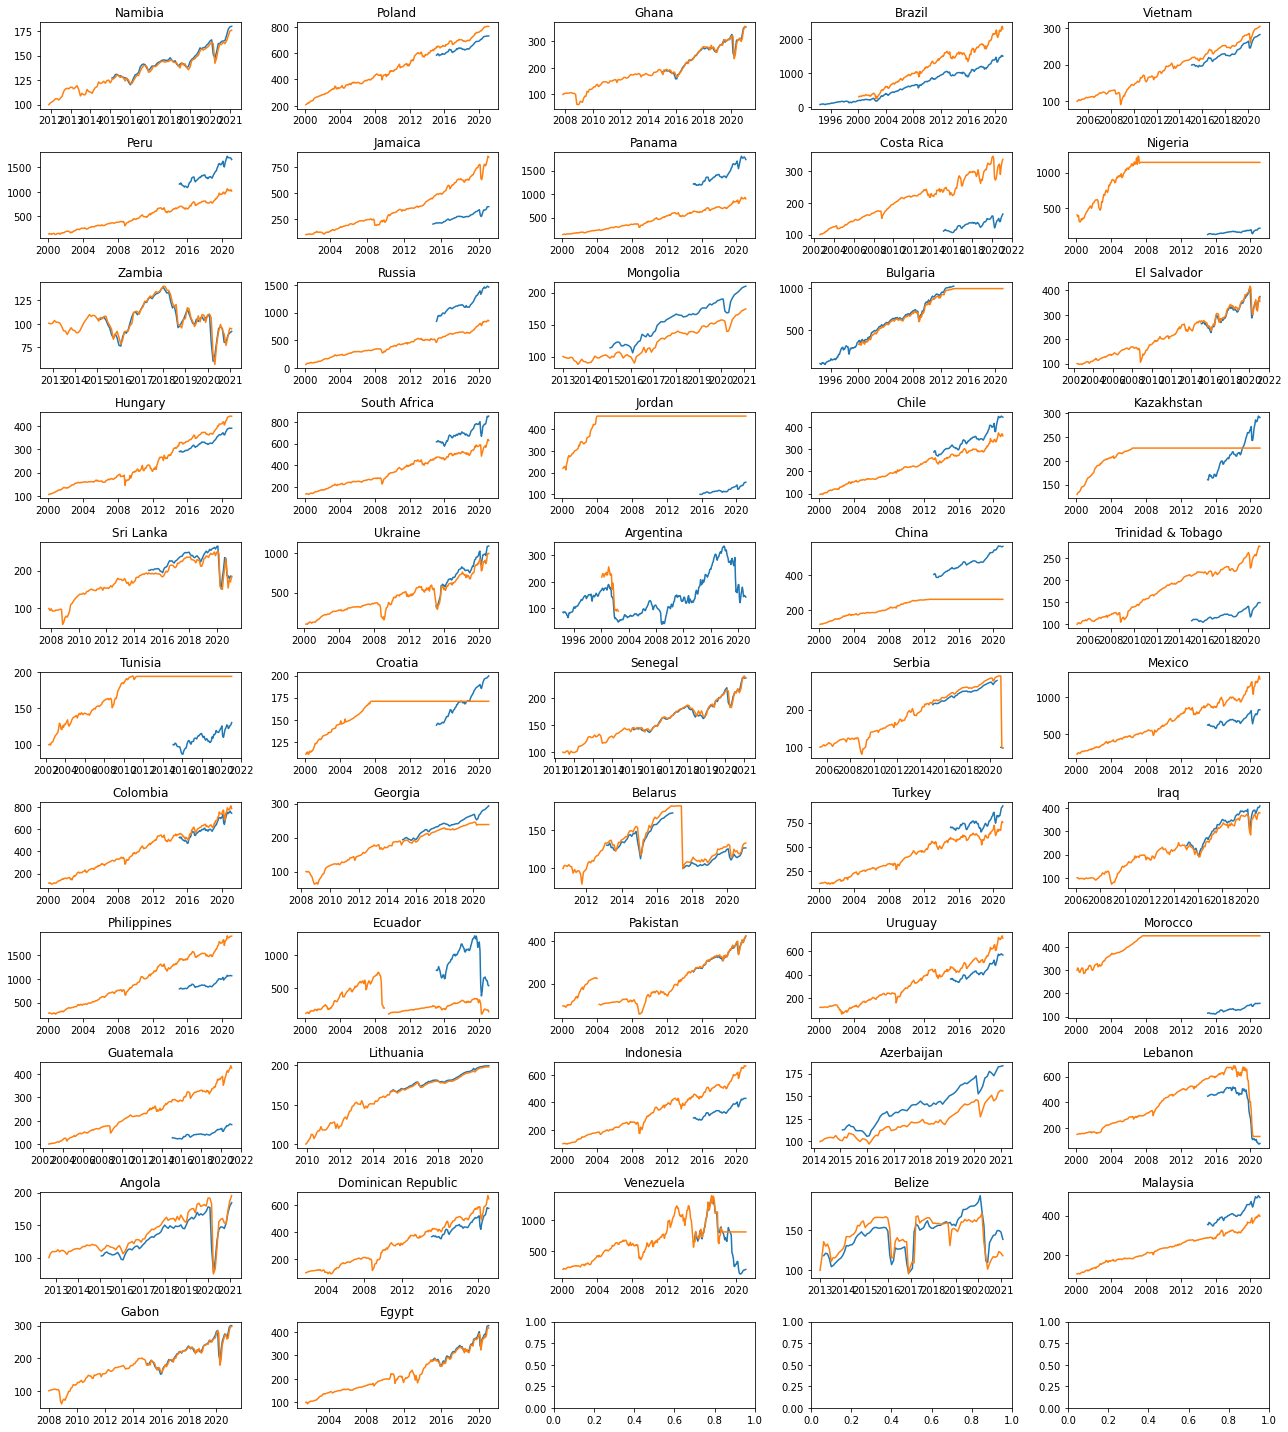

In [23]:
# show plots of original JPM and BofA indices
fig, ax = plt.subplots(ncols=5, nrows=11, figsize=(18, 20))
ax = ax.ravel()
i = 0
for c in common_countries:
    ax[i].plot(bnd_idx_price.index, bnd_idx_price[c])
    ax[i].plot(bnd_idx_price_bofa_monthly.index, bnd_idx_price_bofa_monthly[c])
    ax[i].set_title(c)
    i += 1
    
fig.tight_layout()

In [24]:
bnd_idx_price_bofa_monthly['China']

Date
2000-01-31    120.839
2000-02-29    122.224
2000-03-31    123.342
2000-04-30    122.709
2000-05-31    123.254
               ...   
2020-09-30    263.393
2020-10-31    263.393
2020-11-30    263.393
2020-12-31    263.393
2021-01-31    263.393
Freq: M, Name: China, Length: 253, dtype: float64